Using 576 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Accuracy score of the training data: 0.7881944444444444
Accuracy score of the test data: 0.7708333333333334
The person is not diabetic.


100%|██████████| 192/192 [02:50<00:00,  1.13it/s]


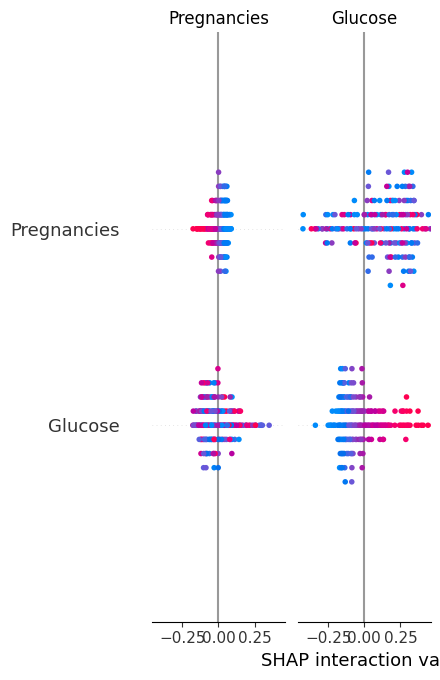

In [20]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import pickle
import shap

# Load the diabetes dataset to a pandas DataFrame
diabetes_dataset = pd.read_csv(r"C:\Users\Ramachandra\OneDrive\Desktop\6th sem miniproject\diabetes (2).csv")

# Separating the data and labels
X = diabetes_dataset.drop(columns='Outcome', axis=1)
Y = diabetes_dataset['Outcome']

# Standardizing the data
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

# Splitting the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_standardized, Y, test_size=0.25, stratify=Y, random_state=2)

# Creating and training the Multi-Layer Perceptron Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,75,50,25), max_iter=10, random_state=2)
mlp_classifier.fit(X_train, Y_train)

# Evaluating the model
training_data_accuracy = accuracy_score(Y_train, mlp_classifier.predict(X_train))
test_data_accuracy = accuracy_score(Y_test, mlp_classifier.predict(X_test))

print('Accuracy score of the training data:', training_data_accuracy)
print('Accuracy score of the test data:', test_data_accuracy)

# Example input data
input_data = [[1, 85, 66, 29, 0, 26.6, 0.351, 31]]

# Standardizing the input data
input_data_standardized = scaler.transform(input_data)

# Making a prediction
prediction = mlp_classifier.predict(input_data_standardized)

if prediction[0] == 0:
    print('The person is not diabetic.')
else:
    print('The person is diabetic.')

# Saving the model
filename = 'diabetes_mlp_model.sav'
pickle.dump(mlp_classifier, open(filename, 'wb'))

# Create a SHAP KernelExplainer and compute SHAP values
explainer = shap.KernelExplainer(mlp_classifier.predict_proba, X_train)
shap_values = explainer.shap_values(X_test)

# Initialize the JavaScript library for SHAP plots
shap.initjs()

# Plot the SHAP values
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

# Show the force plot for the prediction
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test)


Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best Parameters: {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 32, 'hidden_layer_sizes': (200, 150, 100, 50), 'learning_rate_init': 0.0005, 'solver': 'adam'}
Accuracy on training data: 0.7931596091205212
Accuracy on test data: 0.7727272727272727
LIME Explanation:
[('Glucose <= -0.72', -0.29642608122728276), ('BMI <= -0.60', -0.1465281873957241), ('Pregnancies <= -0.86', -0.0851597058436478), ('-0.70 < DiabetesPedigreeFunction <= -0.29', -0.05200210905129797), ('-0.34 < BloodPressure <= 0.15', -0.009049853825353267)]


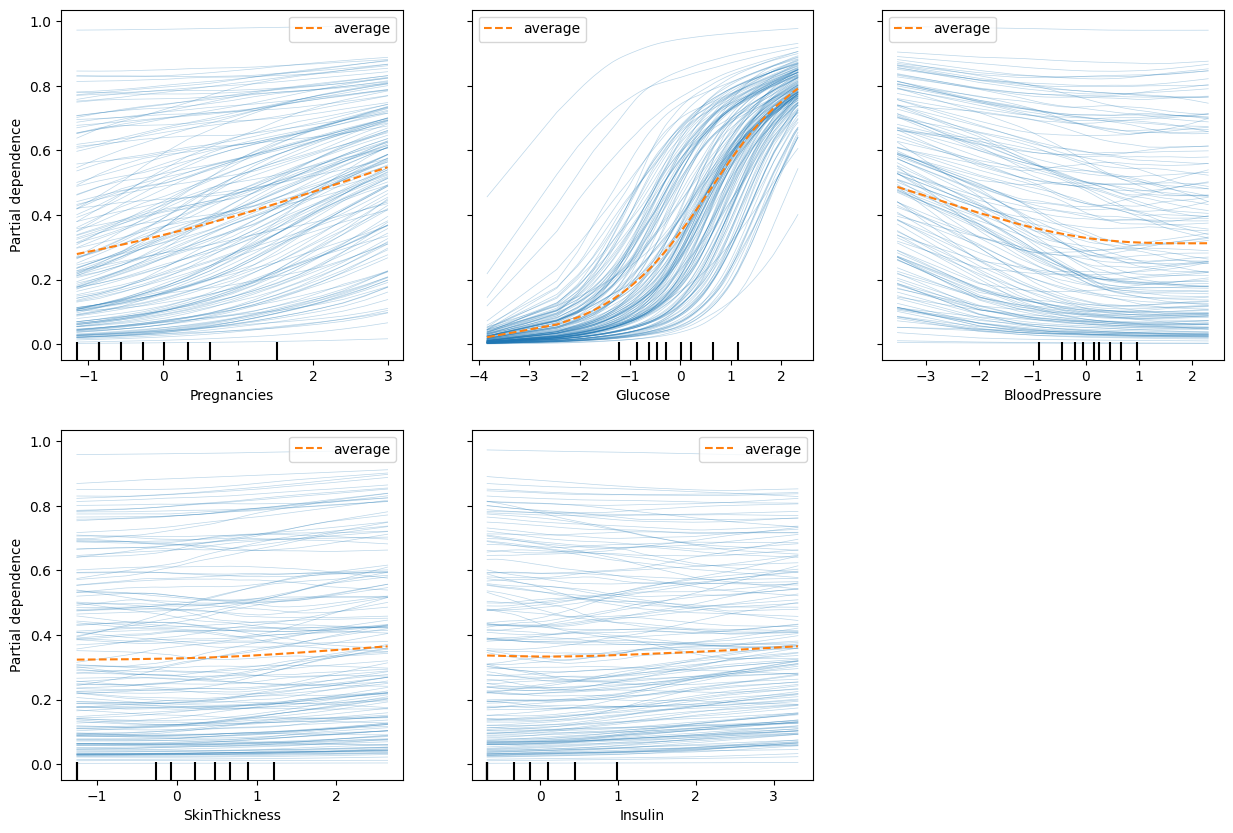

In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import pickle
from lime.lime_tabular import LimeTabularExplainer
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Load the diabetes dataset
diabetes_dataset = pd.read_csv(r"C:\Users\Ramachandra\OneDrive\Desktop\6th sem miniproject\diabetes (2).csv")

# Separate features and target variable
X = diabetes_dataset.drop(columns='Outcome', axis=1)
Y = diabetes_dataset['Outcome']

# Split data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize MLPClassifier with initial parameters
mlp_classifier = MLPClassifier(random_state=2, max_iter=3000, early_stopping=True)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'hidden_layer_sizes': [(200, 150, 100, 50), (250, 200, 150, 100, 50), (300, 200, 100)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.0005, 0.001, 0.005],
    'learning_rate_init': [0.0005, 0.001, 0.005],
    'solver': ['adam', 'sgd'],
    'batch_size': [32, 64, 128],
}

# Perform grid search to find the best parameters
grid_search = GridSearchCV(mlp_classifier, param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, Y_train)

# Get the best model from grid search
best_mlp_classifier = grid_search.best_estimator_

# Model evaluation using accuracy score
train_accuracy = accuracy_score(Y_train, best_mlp_classifier.predict(X_train_scaled))
test_accuracy = accuracy_score(Y_test, best_mlp_classifier.predict(X_test_scaled))

print("Best Parameters:", grid_search.best_params_)
print("Accuracy on training data:", train_accuracy)
print("Accuracy on test data:", test_accuracy)

# Save the best MLP model using pickle
filename = 'best_diabetes_mlp_model.sav'
pickle.dump(best_mlp_classifier, open(filename, 'wb'))

# Create a LimeTabularExplainer
explainer = LimeTabularExplainer(X_train_scaled, feature_names=X.columns.tolist(), class_names=['Non-Diabetic', 'Diabetic'], discretize_continuous=True)

# Example input data
input_data = np.array([[1, 85, 66, 29, 0, 26.6, 0.351, 31]])

# Standardize the input data
input_data_scaled = scaler.transform(input_data)

# Generate explanations for a single instance
exp = explainer.explain_instance(input_data_scaled[0], best_mlp_classifier.predict_proba, num_features=5)

print('LIME Explanation:')
print(exp.as_list())
exp.show_in_notebook()

# PDP and ICE plots using sklearn.inspection
features_to_plot = [0, 1, 2, 3, 4]  # Indices of features to plot, adjust as necessary

# Plot PDP and ICE for selected features
fig, ax = plt.subplots(figsize=(15, 10))
display = PartialDependenceDisplay.from_estimator(
    best_mlp_classifier, 
    X_test_scaled, 
    features=features_to_plot, 
    feature_names=X.columns, 
    kind="both",  # plot both PDP and ICE
    ax=ax
)
plt.show()


Accuracy on training data: 0.7931596091205212
Accuracy on test data: 0.7597402597402597
LIME Explanation:
[('Glucose <= -0.72', -0.32397728738048276), ('BMI <= -0.60', -0.19332291970974338), ('Pregnancies <= -0.86', -0.09297960636048837), ('-0.70 < DiabetesPedigreeFunction <= -0.29', -0.05592090007743009), ('Insulin <= -0.68', 0.03157878054201442)]


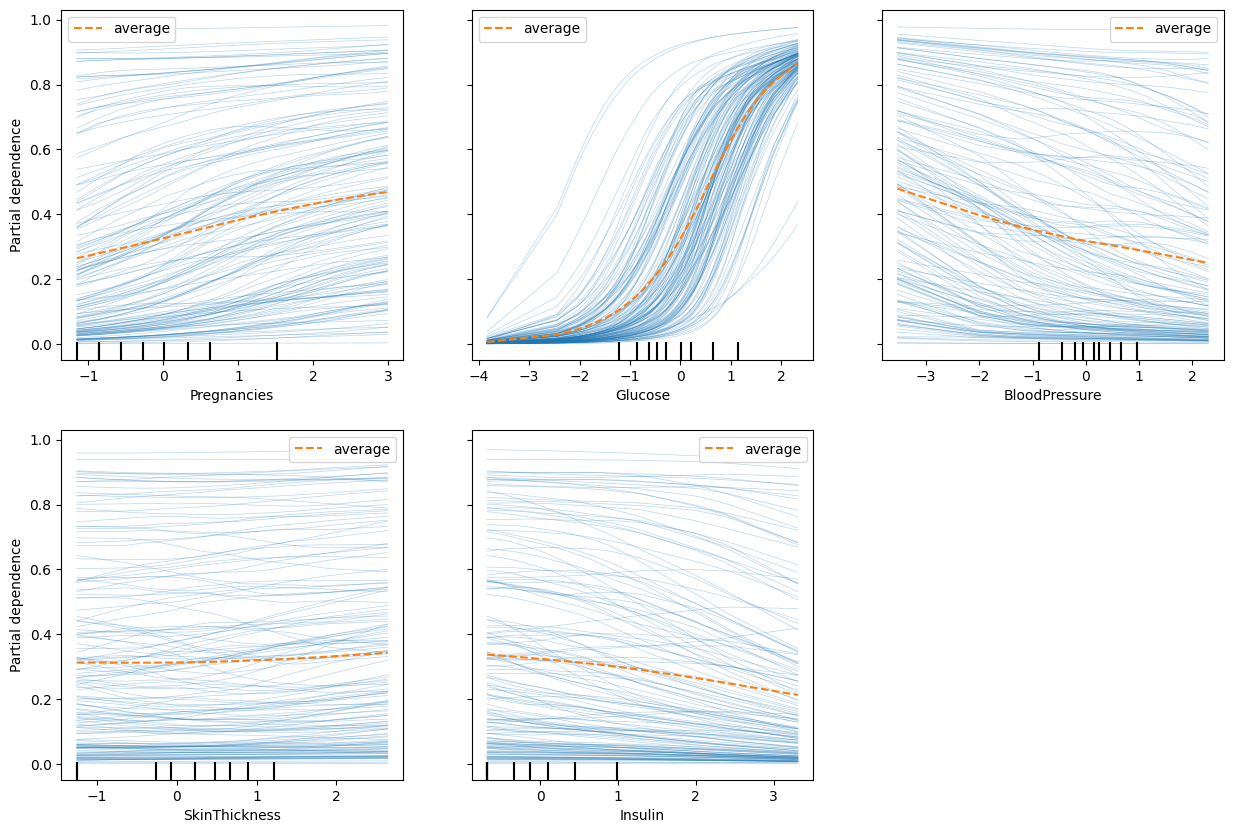

In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import pickle
from lime.lime_tabular import LimeTabularExplainer
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Load the diabetes dataset
diabetes_dataset = pd.read_csv(r"C:\Users\Ramachandra\OneDrive\Desktop\6th sem miniproject\diabetes (2).csv")

# Separate features and target variable
X = diabetes_dataset.drop(columns='Outcome', axis=1)
Y = diabetes_dataset['Outcome']

# Split data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Adjust the MLP model with more layers and neurons
mlp_classifier = MLPClassifier(
    hidden_layer_sizes=(300, 200, 100, 50),  # Increased number of layers and neurons
    activation='relu',
    alpha=0.00035,
    solver='adam',
    learning_rate_init=0.001,
    max_iter=5000,
    random_state=2,
    early_stopping=True
)

# Train the MLP classifier
mlp_classifier.fit(X_train_scaled, Y_train)

# Model evaluation using accuracy score
train_accuracy = accuracy_score(Y_train, mlp_classifier.predict(X_train_scaled))
test_accuracy = accuracy_score(Y_test, mlp_classifier.predict(X_test_scaled))

print("Accuracy on training data:", train_accuracy)
print("Accuracy on test data:", test_accuracy)

# Save the best MLP model using pickle
filename = 'best_diabetes_mlp_model.sav'
pickle.dump(mlp_classifier, open(filename, 'wb'))

# Create a LimeTabularExplainer
explainer = LimeTabularExplainer(X_train_scaled, feature_names=X.columns.tolist(), class_names=['Non-Diabetic', 'Diabetic'], discretize_continuous=True)

# Example input data
input_data = np.array([[1, 85, 66, 29, 0, 26.6, 0.351, 31]])

# Standardize the input data
input_data_scaled = scaler.transform(input_data)

# Generate explanations for a single instance
exp = explainer.explain_instance(input_data_scaled[0], mlp_classifier.predict_proba, num_features=5)

print('LIME Explanation:')
print(exp.as_list())
exp.show_in_notebook()

# PDP and ICE plots using sklearn.inspection
features_to_plot = [0, 1, 2, 3, 4]  # Indices of features to plot, adjust as necessary

# Plot PDP and ICE for selected features
fig, ax = plt.subplots(figsize=(15, 10))
display = PartialDependenceDisplay.from_estimator(
    mlp_classifier, 
    X_test_scaled, 
    features=features_to_plot, 
    feature_names=X.columns, 
    kind="both",  # plot both PDP and ICE
    ax=ax
)
plt.show()
